### Importing Libs

In [2]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Discretization,
    Embedding,
    Flatten,
    Input,
    Lambda,
)
from tensorflow.keras.layers.experimental.preprocessing import HashedCrossing

logging.getLogger("tensorflow").setLevel(logging.ERROR)

2023-05-18 21:53:12.912850: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 21:53:12.961416: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 21:53:12.962462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 21:53:13.860482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Input Pipeline

In [4]:
CSV_COLUMNS = [
    "fare_amount",
    "pickup_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
    "key",
]
LABEL_COLUMN = "fare_amount"
DEFAULTS = [[0.0], ["na"], [0.0], [0.0], [0.0], [0.0], [0.0], ["na"]]
UNWANTED_COLS = ["pickup_datetime", "key"]

INPUT_COLS = [
    c for c in CSV_COLUMNS if c != LABEL_COLUMN and c not in UNWANTED_COLS
]

In [5]:
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data

    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


def load_dataset(pattern, batch_size=1, mode="eval"):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS
    )
    dataset = dataset.map(features_and_labels)  # features, label
    if mode == "train":
        dataset = dataset.shuffle(1000).repeat()
        dataset = dataset.prefetch(1)
    return dataset

### Baseline DNN

In [7]:
def rmse(y_true, y_pred):  # Root mean square error
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_dnn_model():
    inputs = {
        colname: Input(name=colname, shape=(1,), dtype="float32")
        for colname in INPUT_COLS
    }

    concat_inputs = Concatenate()(inputs.values())

    h1 = Dense(32, activation="relu", name="h1")(concat_inputs)
    h2 = Dense(8, activation="relu", name="h2")(h1)

    output = Dense(1, activation="linear", name="fare")(h2)
    model = models.Model(inputs, output)

    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

    return model

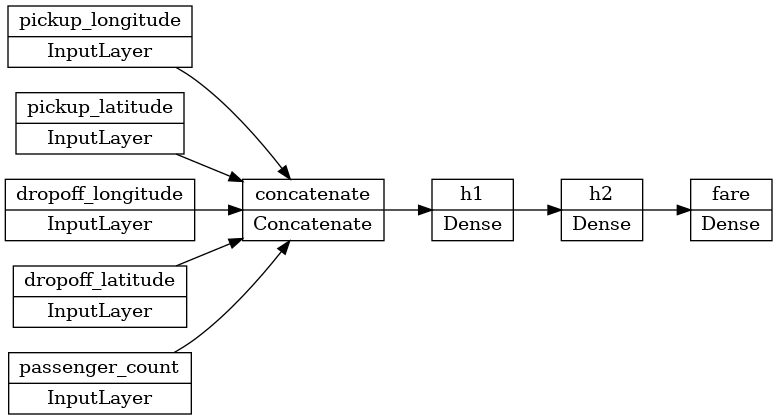

In [8]:
model = build_dnn_model()

tf.keras.utils.plot_model(
    model, "dnn_model.png", show_shapes=False, rankdir="LR"
)

### Train the model

In [10]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5
NUM_EVALS = 5
NUM_EVAL_EXAMPLES = 1000

In [12]:
trainds = load_dataset("../datasets/taxi-train*", TRAIN_BATCH_SIZE, "train")
evalds = load_dataset("../datasets/taxi-valid*", 1000, "eval").take(
    NUM_EVAL_EXAMPLES // 1000
)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
)

Epoch 1/5


2023-05-18 21:55:02.135469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-18 21:55:02.135897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


297/312 [===========================>..] - ETA: 0s - loss: 95.2979 - rmse: 9.2559 - mse: 95.2979

2023-05-18 21:55:05.118706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-18 21:55:05.119030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


312/312 [==============================] - 3s 3ms/step - loss: 95.4754 - rmse: 9.2735 - mse: 95.4754 - val_loss: 107.7450 - val_rmse: 10.3800 - val_mse: 107.7450
Epoch 2/5
312/312 [==============================] - 1s 3ms/step - loss: 95.0278 - rmse: 9.1065 - mse: 95.0278 - val_loss: 114.2490 - val_rmse: 10.6887 - val_mse: 114.2490
Epoch 3/5
312/312 [==============================] - 1s 3ms/step - loss: 95.7342 - rmse: 9.1920 - mse: 95.7342 - val_loss: 115.5115 - val_rmse: 10.7476 - val_mse: 115.5115
Epoch 4/5
312/312 [==============================] - 1s 2ms/step - loss: 95.0433 - rmse: 9.1945 - mse: 95.0433 - val_loss: 100.3624 - val_rmse: 10.0181 - val_mse: 100.3624
Epoch 5/5
312/312 [==============================] - 1s 2ms/step - loss: 101.2471 - rmse: 9.3107 - mse: 101.2471 - val_loss: 110.8244 - val_rmse: 10.5273 - val_mse: 110.8244


### Loss curve

In [13]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx + 1)
        plt.plot(history.history[key])
        plt.plot(history.history[f"val_{key}"])
        plt.title(f"model {key}")
        plt.ylabel(key)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left");

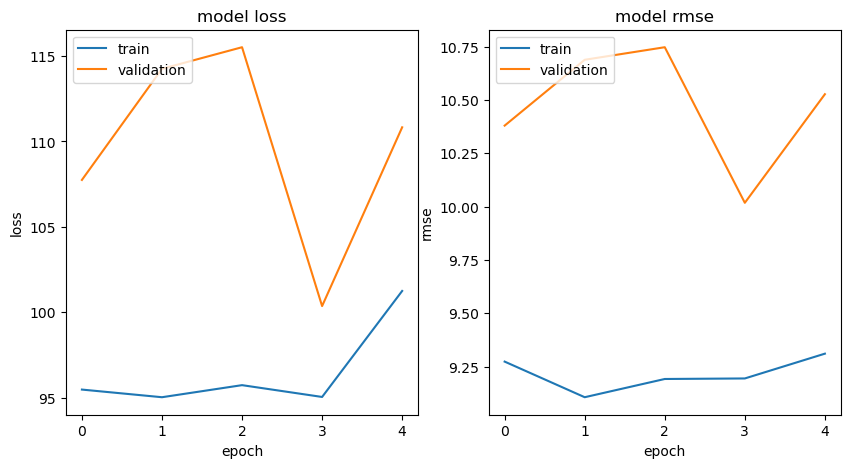

In [14]:
plot_curves(history, ["loss", "rmse"])

### Predict the model locally

In [16]:
model.predict(
    {
        "pickup_longitude": tf.convert_to_tensor([-73.982683]),
        "pickup_latitude": tf.convert_to_tensor([40.742104]),
        "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
        "dropoff_latitude": tf.convert_to_tensor([40.755174]),
        "passenger_count": tf.convert_to_tensor([3.0]),
    },
    steps=1,
)

1/1 [==============================] - 0s 81ms/step


array([[9.654092]], dtype=float32)

### Feature Engineering Pipeline

In [18]:
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff * londiff + latdiff * latdiff)

In [19]:
def scale_longitude(lon_column):
    return (lon_column + 78) / 8.0

In [20]:
def scale_latitude(lat_column):
    return (lat_column - 37) / 8.0

In [21]:
NBUCKETS = 10

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def build_dnn_model():
    inputs = {
        colname: Input(name=colname, shape=(1,), dtype="float32")
        for colname in INPUT_COLS
    }

    transformed = {}

    transformed["scaled_plon"] = Lambda(scale_longitude, name="scale_plon")(
        inputs["pickup_longitude"]
    )
    transformed["scaled_dlon"] = Lambda(scale_longitude, name="scale_dlon")(
        inputs["dropoff_longitude"]
    )

    transformed["scaled_plat"] = Lambda(scale_latitude, name="scale_plat")(
        inputs["pickup_latitude"]
    )
    transformed["scaled_dlat"] = Lambda(scale_latitude, name="scale_dlat")(
        inputs["dropoff_latitude"]
    )

    transformed["euclidean_distance"] = Lambda(euclidean, name="euclidean")(
        [
            inputs["pickup_longitude"],
            inputs["pickup_latitude"],
            inputs["dropoff_longitude"],
            inputs["dropoff_latitude"],
        ]
    )

    latbuckets = np.linspace(start=0.0, stop=1.0, num=NBUCKETS).tolist()
    lonbuckets = np.linspace(start=0.0, stop=1.0, num=NBUCKETS).tolist()

    plon = Discretization(lonbuckets, name="plon_bkt")(
        transformed["scaled_plon"]
    )
    plat = Discretization(latbuckets, name="plat_bkt")(
        transformed["scaled_plat"]
    )
    dlon = Discretization(lonbuckets, name="dlon_bkt")(
        transformed["scaled_dlon"]
    )
    dlat = Discretization(latbuckets, name="dlat_bkt")(
        transformed["scaled_dlat"]
    )

    p_fc = HashedCrossing(num_bins=NBUCKETS * NBUCKETS, name="p_fc")(
        (plon, plat)
    )
    d_fc = HashedCrossing(num_bins=NBUCKETS * NBUCKETS, name="d_fc")(
        (dlon, dlat)
    )
    pd_fc = HashedCrossing(num_bins=NBUCKETS**4, name="pd_fc")((p_fc, d_fc))

    transformed["pd_embed"] = Flatten()(
        Embedding(input_dim=NBUCKETS**4, output_dim=10, name="pd_embed")(
            pd_fc
        )
    )

    transformed["passenger_count"] = inputs["passenger_count"]
    dnn_inputs = Concatenate()(transformed.values())

    h1 = Dense(32, activation="relu", name="h1")(dnn_inputs)
    h2 = Dense(8, activation="relu", name="h2")(h1)

    output = Dense(1, activation="linear", name="fare")(h2)
    model = models.Model(inputs, output)

    model.compile(optimizer="adam", loss="mse", metrics=[rmse])
    return model

In [22]:
model = build_dnn_model()

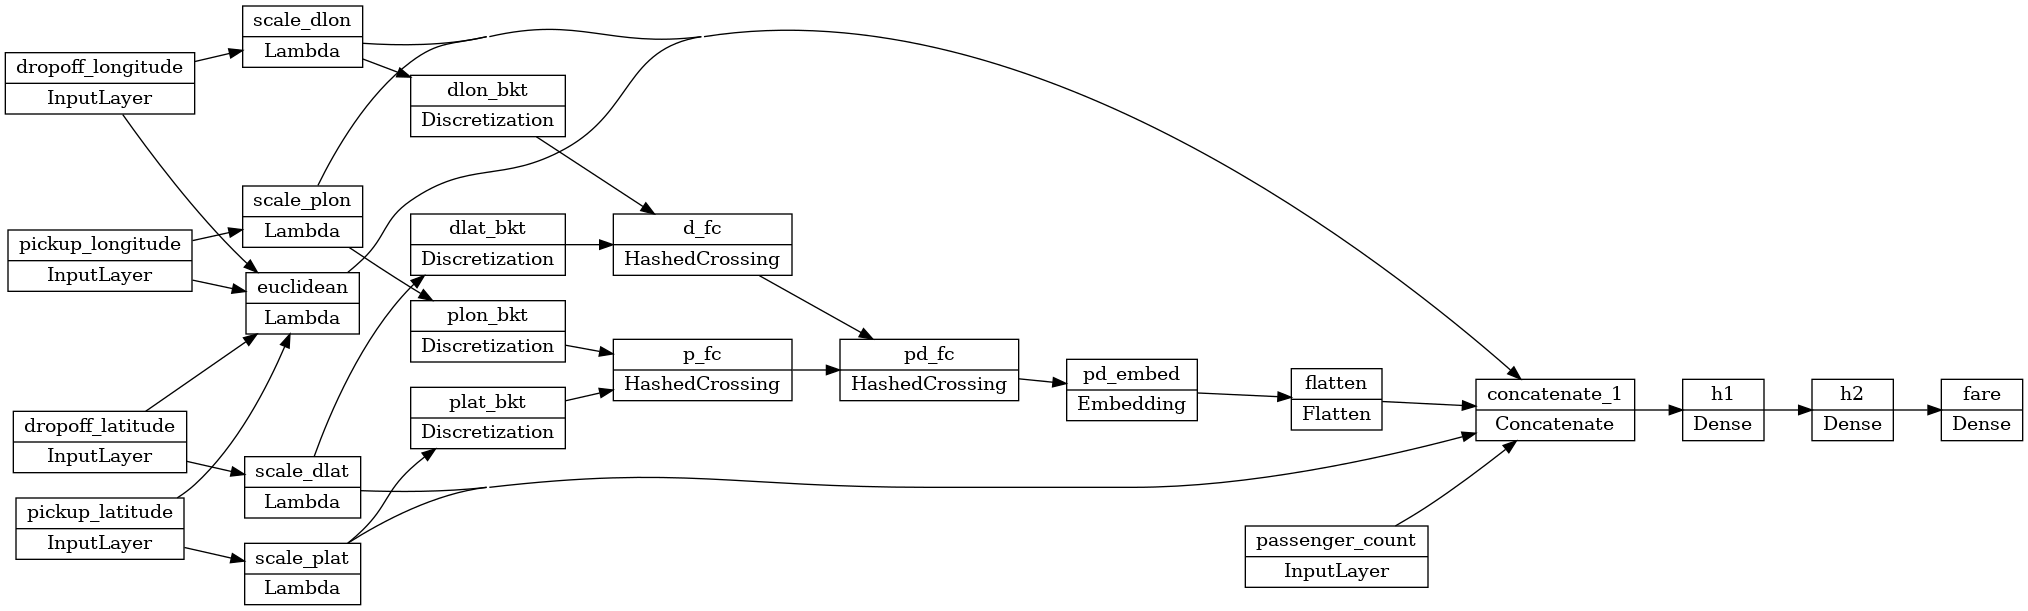

In [23]:
tf.keras.utils.plot_model(
    model, "dnn_model_engineered.png", show_shapes=False, rankdir="LR"
)

### Train model with engineered features

In [24]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 10
NUM_EVALS = 10
NUM_EVAL_EXAMPLES = 1000

In [26]:
trainds = load_dataset("../datasets/taxi-train*", TRAIN_BATCH_SIZE, "train")
evalds = load_dataset("../datasets/taxi-valid*", 1000, "eval").take(
    NUM_EVAL_EXAMPLES // 1000
)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
)

Epoch 1/10


2023-05-18 21:57:45.369298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-18 21:57:45.369664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


305/312 [============================>.] - ETA: 0s - loss: 158.2903 - rmse: 11.8802

2023-05-18 21:57:49.121309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-18 21:57:49.121798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


312/312 [==============================] - 4s 6ms/step - loss: 157.1413 - rmse: 11.8390 - val_loss: 107.0636 - val_rmse: 10.3472
Epoch 2/10
312/312 [==============================] - 1s 4ms/step - loss: 96.3947 - rmse: 9.1828 - val_loss: 125.3917 - val_rmse: 11.1978
Epoch 3/10
312/312 [==============================] - 1s 3ms/step - loss: 96.2262 - rmse: 9.1171 - val_loss: 101.7536 - val_rmse: 10.0873
Epoch 4/10
312/312 [==============================] - 1s 3ms/step - loss: 89.8651 - rmse: 8.9161 - val_loss: 120.0812 - val_rmse: 10.9582
Epoch 5/10
312/312 [==============================] - 1s 4ms/step - loss: 86.9570 - rmse: 8.7130 - val_loss: 77.8119 - val_rmse: 8.8211
Epoch 6/10
312/312 [==============================] - 1s 4ms/step - loss: 91.9715 - rmse: 8.9594 - val_loss: 92.7296 - val_rmse: 9.6296
Epoch 7/10
312/312 [==============================] - 1s 4ms/step - loss: 82.4174 - rmse: 8.5413 - val_loss: 92.2570 - val_rmse: 9.6050
Epoch 8/10
312/312 [=============================

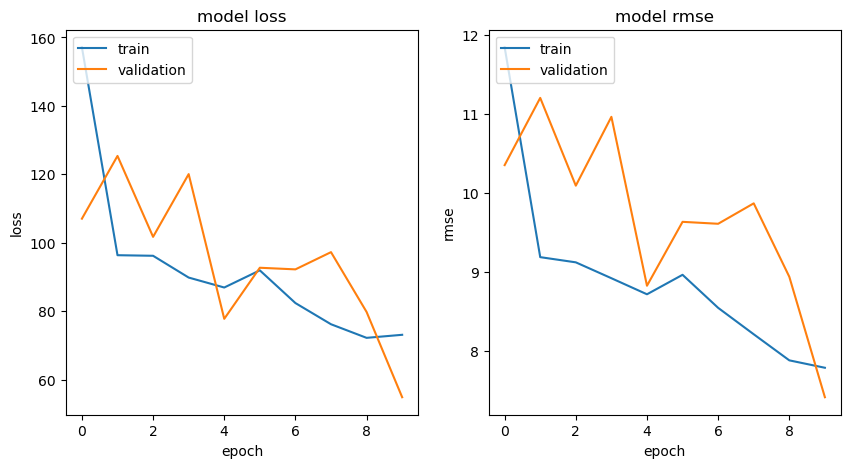

In [27]:
plot_curves(history, ["loss", "rmse"])

In [28]:
model.predict(
    {
        "pickup_longitude": tf.convert_to_tensor([-73.982683]),
        "pickup_latitude": tf.convert_to_tensor([40.742104]),
        "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
        "dropoff_latitude": tf.convert_to_tensor([40.755174]),
        "passenger_count": tf.convert_to_tensor([3.0]),
    },
    steps=1,
)

1/1 [==============================] - 0s 105ms/step


array([[10.386304]], dtype=float32)